<h1><center>Data Analytics on Player Performance in Major League Baseball</center></h1>
<h2><center>Chris Emm</center></h2>

In [239]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

### Introduction

Baseball is a game of scoring runs. There's a reason that the team with the most runs at the end of a game wins. Major Leage Baseball (MLB), especially in the past 20 years has seen an uptick of scoring, as the game has become more and more about offensive firepower rather than pitchers completely dominating the hitters. A team's front office and everyone that is included into the decision making behind roster formations need to be able to analyze player performance and determine which players will score them the most runs, and in effect, help them win the most games. In this project, we will analyze which offensive metrics are most closely related to scoring runs, using team data between 2011-2021. Then, based on our findings, we will then create a predictive model that will extrapolate which players are most likely to perform well with regards to the metrics we deem to important in driving in runs.

### Part I: Scraping Team Data for 2011-2021 Seasons

The first thing we are going to do is analyze a variety of offensive metrics and their relation to producing runs on offense. In order to do this, we will need to scrape team data from FanGraphs (https://www.fangraphs.com/). We will gather basic, advanced, and batted ball data that each team accumulated over each season for the last decade. Below are two functions that scrape the data from the website.

The following function scrapes the table that is located at the specified url, and creates a dataframe using pandas from the table that is scraped. The additional year and team arguments allow us to add respective columns based on which team each row is for.

In [240]:
def scraping_FanGraphs(url, year, team):
    # Extracting text from webpage
    html = requests.get(url).text

    # Parsing the text into html code
    soup = BeautifulSoup(html,"html.parser")

    # Finding the table in the html code - we are searching by the id of the table
    table = soup.find("table", attrs={"class": "rgMasterTable"})


    table_data = table.tbody.find_all("tr")

    dataset = []
    for tr in table_data:
        temp = ()
        for td in tr.find_all("td"):
            if '\xa0' in td.text:
                temp += ('0.0',)
            else:
                temp += (td.text,)
        dataset.append(temp)

    stats = pd.DataFrame(data = dataset)
    stats = stats.replace(to_replace=" NULL",value=0)

    table_header = table.thead.find_all("tr")
    columns = []
    count = 0
    for tr in table_header:
        if count == 1:
            th = tr.find_all("th")
            for a in th:
                columns.append(a.text)
        count = 1
    stats.columns = columns
    stats = stats.assign(Year = year)
    if team != 'None':
        stats = stats.assign(Team = team)
    
    return stats

The function below simply compiles a list of urls based on which FanGraphs page we want to visit. Since the basic, advanced, and batted ball statistics are on separate urls, we have an argument, stat, which determines which url we are looking to scrape from. This function will be used to create urls for all 30 MLB teams for the years that are specified (2011-2021). The page argument is used because some teams have too many players to fit on one page, so the remaining are placed on separate pages. As you can see, we wil use this function for both team and player scraping.

In [241]:
def get_urls(team, year, page, stat):
    
######################################################################
#                      Player Stats Urls                             #
######################################################################
    if stat == 'player_advanced':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats' \
          '=bat&lg=all&qual=0&type=1&season=' + str(year) + '&month=0&season1=' \
           + str(year) + '&ind=0&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate' \
          '=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31&page=' + str(page) + '_50'
    
    if stat == 'player_batted':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=2&season' \
            '=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01' \
            '&enddate=' + str(year) + '-12-31&page=' + str(page) + '_50'
        
######################################################################
#                        Team Stats Urls                             #
######################################################################

    if stat == 'team':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=0&season=' + str(year) +  \
            '&month=0&season1=' + str(year) + '&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    
    if stat == 'team_advanced':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=1&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&team=0,'\
            'ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    
    if stat == 'team_batted':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=2&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&'\
            'team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    return url

Here we are actually compiling the web scrape results and merging all resulting dataframes into one overall dataframe called team_batting.

In [259]:
years = [i for i in range(2011,2022)]

######################################################################
#              Creating a Dataframe for Team Stats                   #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team')
    if count == 0:
        team_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_batting = pd.concat([team_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_batting = team_batting.drop_duplicates()
team_batting = team_batting.reset_index(drop=True)
team_batting = team_batting[['Year', 'Team', 'AB', 'PA', 'AVG', 'H', '1B', '2B', \
                             '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', \
                             'SF', 'SH', 'GDP', 'SB', 'CS']]

######################################################################
#           Adding Advanced Batting Stats to Dataframe               #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_advanced')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'PA', 'BB%', 'K%', \
                                               'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', \
                                               'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', \
                                               'wRAA', 'wOBA', 'wRC+']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team', 'PA', 'AVG'])

######################################################################
#             Adding Batted Ball Stats to Dataframe                  #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_batted')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'BABIP', 'GB/FB', \
                                               'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', \
                                               'IFH', 'IFH%', 'BUH', 'BUH%', 'Pull%', \
                                               'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team', 'BABIP'])

######################################################################
#              Adding Wins and Losses to Dataframe                   #
######################################################################

teams_table = pd.read_csv('tables/Teams.csv')
teams_table = teams_table[teams_table.yearID > 2010]

teams_table = teams_table.rename(columns = {'yearID':'Year','franchID':'Team'})

# Taking only the necessary columns
teams_table = teams_table[['Year', 'Team', 'W', 'L']]

data = []
for team_index, team_row in teams_table.iterrows():
    for my_team_index, my_team_row in team_batting.iterrows():
        if my_team_row['Team'] == team_row['Team'] and my_team_row['Year'] == team_row['Year']:
            team = list(my_team_row)
            team.append(team_row['W'])
            team.append(team_row['L'])
            team = tuple(team)
            data.append(team)

# Creating a dataframe from the list of tuples above
team_batting = pd.DataFrame(data, columns=['Year', 'Team', 'AB', 'PA', 'AVG', \
                                   'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',\
                                   'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP',\
                                   'SB', 'CS', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG',\
                                   'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', \
                                   'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'GB/FB',\
                                   'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH', \
                                   'IFH%', 'BUH', 'BUH%', 'Pull%', 'Cent%', 'Oppo%',\
                                   'Soft%', 'Med%', 'Hard%', 'W', 'L'])

# Removing the % in the values so that they can be used as numbers
team_batting['BB%'] = team_batting['BB%'].replace({'\%':''}, regex = True)
team_batting['K%'] = team_batting['K%'].replace({'\%':''}, regex = True)
team_batting['LD%'] = team_batting['BB%'].replace({'\%':''}, regex = True)
team_batting['GB%'] = team_batting['GB%'].replace({'\%':''}, regex = True)
team_batting['FB%'] = team_batting['FB%'].replace({'\%':''}, regex = True)
team_batting['IFFB%'] = team_batting['IFFB%'].replace({'\%':''}, regex = True)
team_batting['HR/FB'] = team_batting['HR/FB'].replace({'\%':''}, regex = True)
team_batting['Pull%'] = team_batting['Pull%'].replace({'\%':''}, regex = True)
team_batting['Cent%'] = team_batting['Cent%'].replace({'\%':''}, regex = True)
team_batting['Oppo%'] = team_batting['Oppo%'].replace({'\%':''}, regex = True)
team_batting['Soft%'] = team_batting['Soft%'].replace({'\%':''}, regex = True)
team_batting['Med%'] = team_batting['Med%'].replace({'\%':''}, regex = True)
team_batting['Hard%'] = team_batting['Hard%'].replace({'\%':''}, regex = True)

# Making all values numeric if they have only numbers
team_batting = team_batting.apply(pd.to_numeric, errors='ignore')

# Reordering columns
team_batting = team_batting[['Year', 'Team', 'W', 'L', 'AB', 'PA', 'AVG', \
                             'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',\
                             'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP',\
                             'SB', 'CS', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG',\
                             'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', \
                             'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'GB/FB',\
                             'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH', \
                             'IFH%', 'BUH', 'BUH%', 'Pull%', 'Cent%', 'Oppo%',\
                             'Soft%', 'Med%', 'Hard%']]
team_batting

,Year,Team,W,L,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,BB%,K%,BB/K,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
0,2011,ARI,94,68,5421,6096,0.250,1357,855,293,37,172,731,702,531,55,1249,61,33,50,82,133,55,8.7,20.5,0.43,0.322,0.413,0.736,0.163,5.1,0.294,0.3,8.8,-0.1,710,25.4,0.322,97,1.09,8.7,41.4,38.1,11.7,10.9,98,5.7%,19,18.8%,40.4,34.8,24.8,23.2,49.8,26.9
1,2011,ATL,89,73,5528,6169,0.243,1345,912,244,16,173,641,606,504,45,1260,28,30,75,113,77,44,8.2,20.4,0.40,0.308,0.387,0.695,0.144,3.7,0.284,1.8,0.4,-7.0,638,-55.4,0.306,91,1.27,8.2,45.9,36.1,11.2,11.3,126,6.5%,26,19.3%,40.8,35.3,23.9,24.7,50.8,24.4
2,2011,BAL,69,93,5585,6156,0.257,1434,957,273,13,191,708,684,452,24,1120,52,43,24,154,81,25,7.3,18.2,0.40,0.316,0.413,0.729,0.156,3.9,0.288,-2.4,-10.0,1.1,709,17.6,0.320,96,1.19,7.3,44.2,37.0,10.5,11.6,131,6.6%,23,32.9%,40.2,35.4,24.4,23.0,52.2,24.8
3,2011,BOS,90,72,5710,6414,0.280,1600,1010,352,35,203,875,842,578,52,1108,50,50,22,136,102,42,9.0,17.3,0.52,0.349,0.461,0.810,0.181,4.6,0.314,-10.9,0.6,-1.9,902,181.6,0.352,117,1.15,9.0,42.9,37.4,9.1,11.7,144,7.3%,7,17.1%,41.0,34.2,24.8,21.8,50.1,28.1
4,2011,CHW,79,83,5502,6159,0.252,1387,965,252,16,154,654,625,475,31,989,84,46,52,125,81,53,7.7,16.1,0.48,0.319,0.388,0.706,0.136,3.5,0.280,0.0,0.2,-10.1,673,-19.3,0.312,90,1.16,7.7,43.3,37.4,11.9,9.2,114,5.9%,35,28.9%,43.7,31.8,24.5,24.4,52.7,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2021,SFG,107,55,5462,6196,0.249,1360,823,271,25,241,804,768,602,45,1461,64,30,36,117,66,14,9.7,23.6,0.41,0.329,0.440,0.769,0.191,4.4,0.295,-7.7,-1.1,2.4,823,73.0,0.329,108,1.03,9.7,39.7,38.5,8.3,15.6,98,6.2%,16,23.2%,40.5,35.4,24.2,15.0,53.4,31.5
293,2021,STL,90,72,5351,6001,0.244,1303,822,261,22,198,706,678,478,32,1341,86,44,40,99,89,22,8.0,22.3,0.36,0.313,0.412,0.725,0.168,4.5,0.287,5.5,2.3,3.9,709,-18.2,0.312,97,1.04,8.0,40.5,38.9,9.8,12.6,117,7.2%,10,14.9%,42.0,34.3,23.7,16.0,51.7,32.3
294,2021,TEX,60,102,5405,5943,0.232,1254,838,225,24,167,625,598,433,10,1381,58,31,16,113,106,29,7.3,23.2,0.31,0.294,0.375,0.670,0.143,4.7,0.280,-3.7,-2.6,4.5,606,-113.9,0.291,84,1.34,7.3,46.4,34.6,9.2,12.0,124,6.6%,5,11.4%,38.1,36.1,25.8,16.1,52.7,31.2
295,2021,TOR,91,71,5476,6070,0.266,1455,895,285,13,262,846,816,496,14,1218,51,35,10,112,81,20,8.2,20.1,0.41,0.330,0.466,0.797,0.200,4.2,0.296,0.6,-0.7,2.9,864,129.4,0.340,112,1.04,8.2,40.4,38.8,10.3,15.8,128,7.4%,7,31.8%,41.0,33.6,25.4,14.9,51.6,33.6


#### Correlation Between Runs and Various Offensive Metrics

Since the team that has more runs wins the game, run are directly correlated to winning games. Obviously, that is a generic statement that can have some nuance; of course, a team that scores a lot of runs but gives up even more runs, will lose games, so really a team's Run%, Runs Scored / (Runs Scored + Runs Scored), is more directly related to winning, but we aren't worried about defense for this exercise.
<br /><br /> Below, we are going to try to find the offensive metric(s) that best correlate with scoring runs, because scoring runs wins games, to an extent. We will plot the important metrics, described below, against a team's run total and find the correlation between the datapoints. This will show which stat is most correlated to scoring runs, and thus the stat that is likely important in terms of helping a team win games. Below are the metrics that we will be analyzing:

<br />**AVG: Batting Average**
> The percentage of times the batter gets a hit of out of all of his at-bats.
<br />**Formula:** H / AB

<br />**OBP: On-Base Percentage**
> The ratio of the sum of the batter's hits, walks, hit by pitches to their number of plate appearances. 
<br />**Formula:** (H + BB + HBP) / PA

<br />**SLG: Slugging Percentage**
> The total number of bases a player records per at-bat.
<br />**Formula:** (1B + 2(2B) + 3(3B) + 4(HR)) / AB

<br />**OPS: On-Base Plus Slugging Percentage**
> The ratio of the sum of the batter's hits, walks, hit by pitches to their number of plate appearances plus the total number of bases a player records per at-bat.
<br />**Formula:** ((H + BB + HBP) / PA) + ((1B + 2(2B) + 3(3B) + 4(HR)) / AB)

<br />**wOBA: Weighted On-Base Average**
> Metric designed to measure a player's overall offensive contributions per plate appearance.
<br />**Formula:** (0.690(BB – IBB) + 0.722(HBP) + 0.888(1B) + 1.271(2B) + 1.616(3B) + 2.101(HR)) / (AB + BB – IBB + SF + HBP)

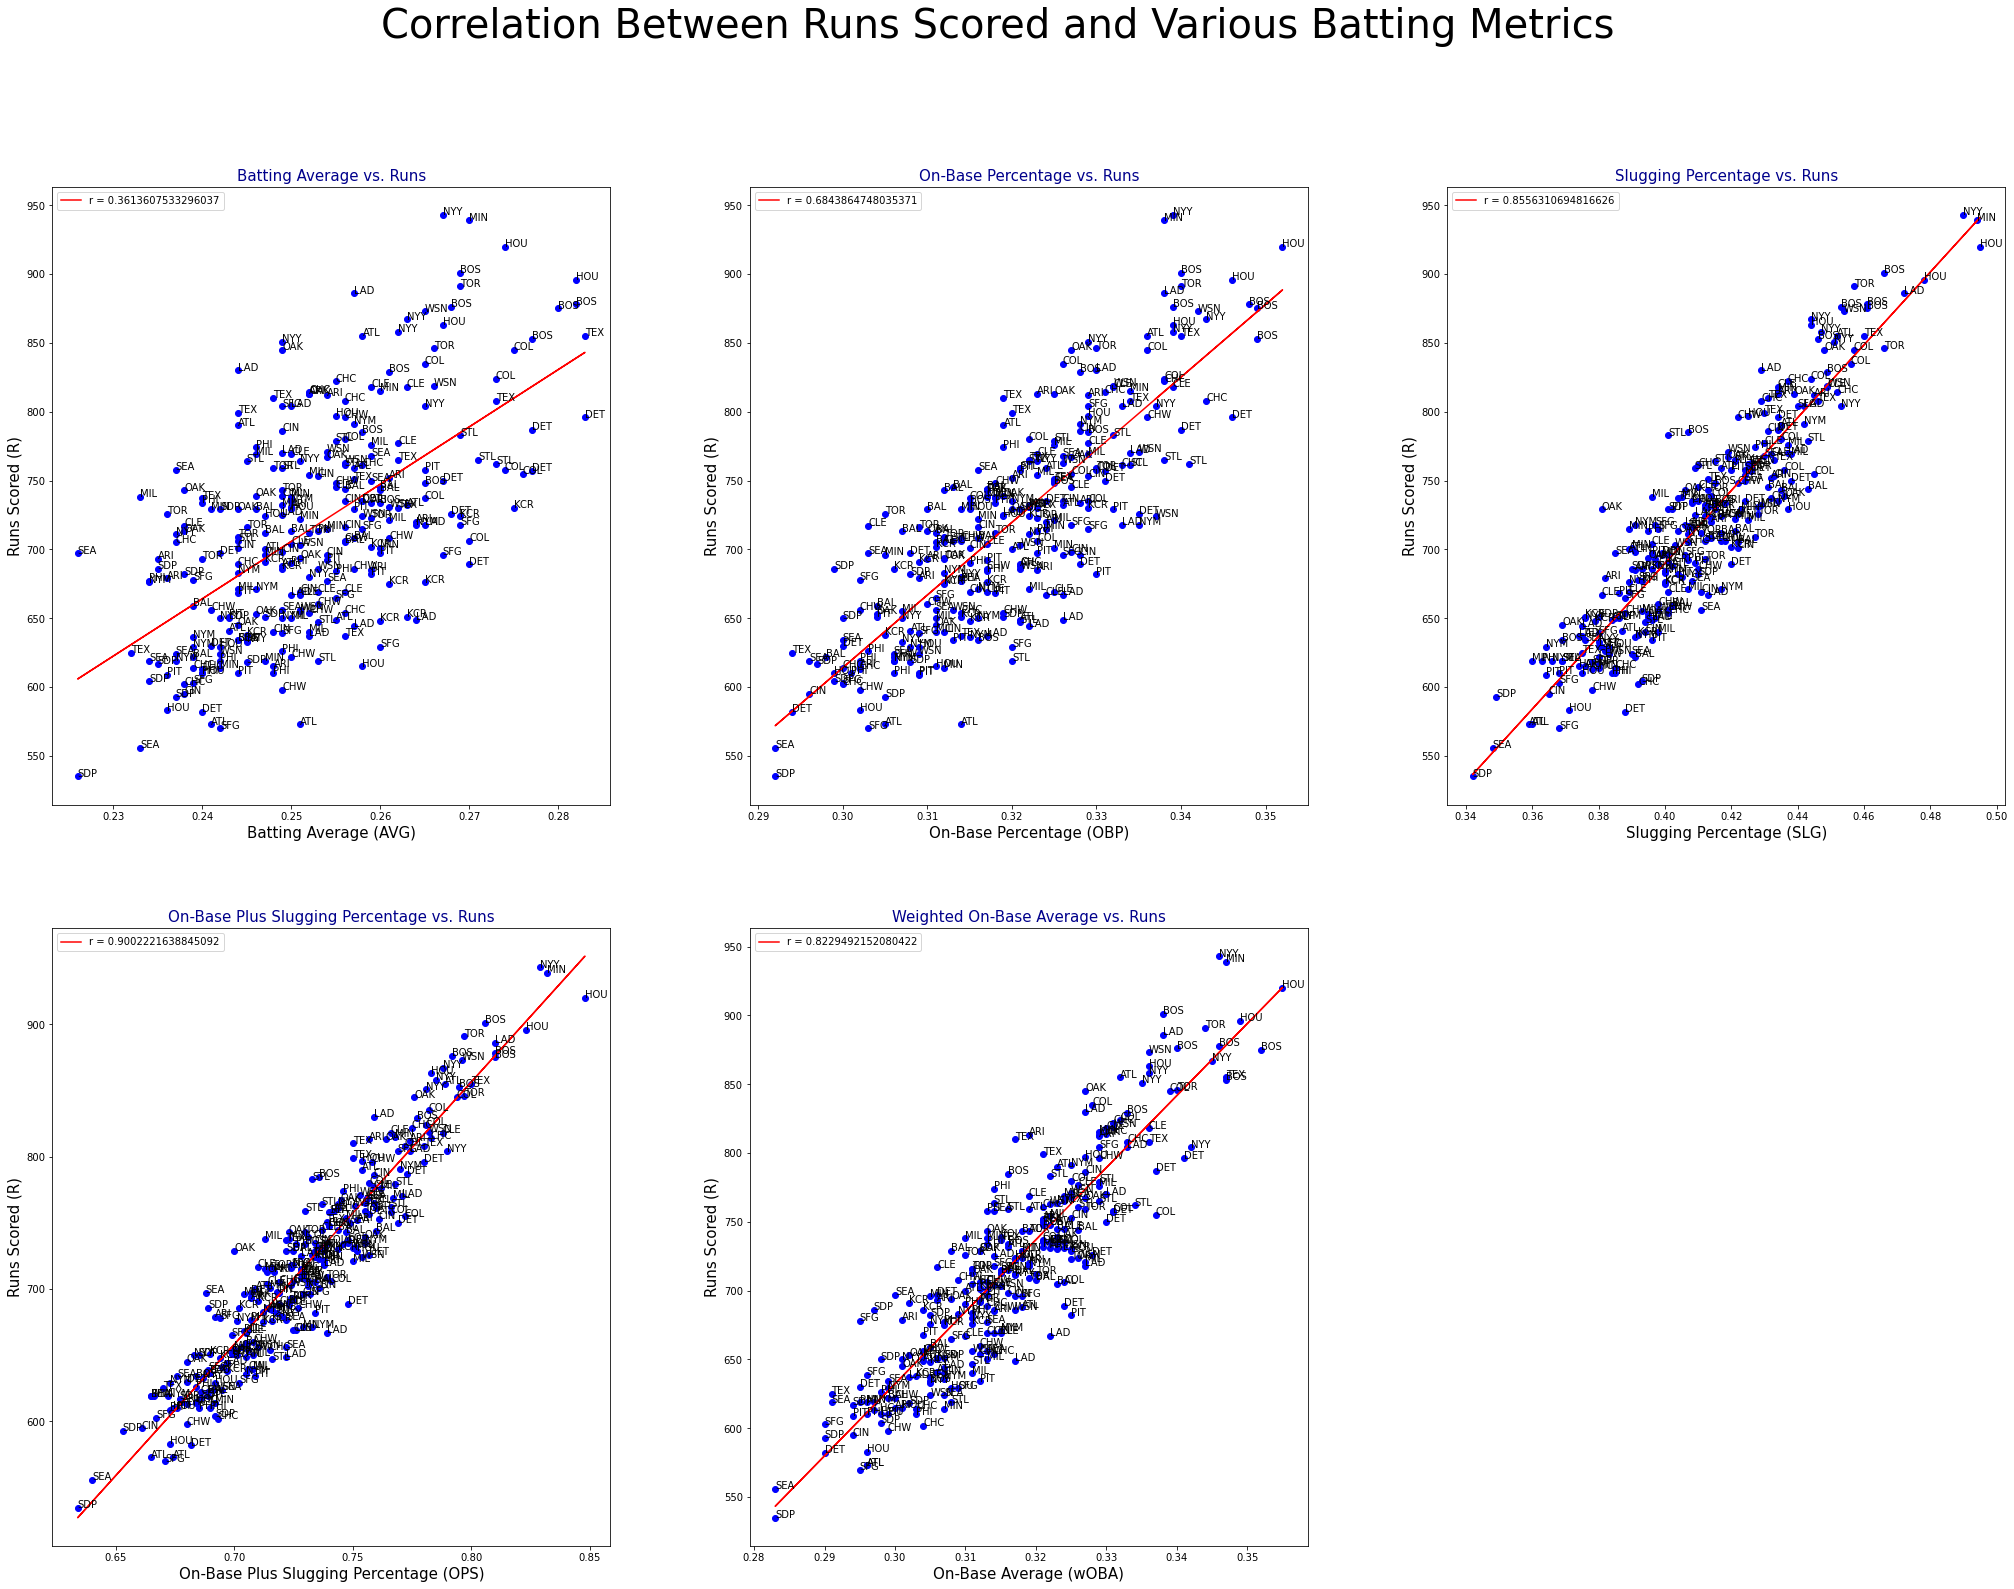

In [260]:
# 2020 was shortened due to COVID, so only 60 regular season games were played meaning less runs were scored,
# so we will ignore that for this exercise
team = team_batting[team_batting.Year != 2020]

fig, ax = plt.subplots(2, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(25)
fig.set_figwidth(35)
fig.delaxes(ax[1,2])
fig.suptitle("Correlation Between Runs Scored and Various Batting Metrics", fontsize=40)


######################################################################
#       Plotting Correlation Batting Average vs. Runs Scored         #
######################################################################

plt.sca(ax[0,0])
plt.gca().set_title('Batting Average vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Batting Average (AVG)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['AVG'], row['R']))
    
# Calculate regression line and plot it in the same graph\
reg = LinearRegression().fit(team['AVG'].values.reshape(-1,1), team['R'].values)
prediction = reg.predict(team['AVG'].values.reshape(-1,1))

plt.plot(team['AVG'], prediction, label = f'r = {reg.score(team.AVG.values.reshape(-1,1), team.R.values)}', color='red')
plt.scatter(team['AVG'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation OBP vs. Runs Scored                 #
######################################################################

plt.sca(ax[0,1])
plt.gca().set_title('On-Base Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Percentage (OBP)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['OBP'], row['R']))
    
# Calculate regression line and plot it in the same graph\
reg = LinearRegression().fit(team['OBP'].values.reshape(-1,1), team['R'].values)
prediction = reg.predict(team['OBP'].values.reshape(-1,1))

plt.plot(team['OBP'], prediction, label = f'r = {reg.score(team.OBP.values.reshape(-1,1), team.R.values)}', color='red')
plt.scatter(team['OBP'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation SLG vs. Runs Scored                 #
######################################################################

plt.sca(ax[0,2])
plt.gca().set_title('Slugging Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Slugging Percentage (SLG)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['SLG'], row['R']))
    
# Calculate regression line and plot it in the same graph\
reg = LinearRegression().fit(team['SLG'].values.reshape(-1,1), team['R'].values)
prediction = reg.predict(team['SLG'].values.reshape(-1,1))

plt.plot(team['SLG'], prediction, label = f'r = {reg.score(team.SLG.values.reshape(-1,1), team.R.values)}', color='red')
plt.scatter(team['SLG'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation OPS vs. Runs Scored                 #
######################################################################

plt.sca(ax[1,0])
plt.gca().set_title('On-Base Plus Slugging Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Plus Slugging Percentage (OPS)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['OPS'], row['R']))
    
# Calculate regression line and plot it in the same graph\
reg = LinearRegression().fit(team['OPS'].values.reshape(-1,1), team['R'].values)
prediction = reg.predict(team['OPS'].values.reshape(-1,1))

plt.plot(team['OPS'], prediction, label = f'r = {reg.score(team.OPS.values.reshape(-1,1), team.R.values)}', color='red')
plt.scatter(team['OPS'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation wOBA vs. Runs Scored                #
######################################################################

plt.sca(ax[1,1])
plt.gca().set_title('Weighted On-Base Average vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Average (wOBA)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['wOBA'], row['R']))
    
# Calculate regression line and plot it in the same graph\
reg = LinearRegression().fit(team['wOBA'].values.reshape(-1,1), team['R'].values)
prediction = reg.predict(team['wOBA'].values.reshape(-1,1))

plt.plot(team['wOBA'], prediction, label = f'r = {reg.score(team.wOBA.values.reshape(-1,1), team.R.values)}', color='red')
plt.scatter(team['wOBA'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

plt.show()

### Part II: Scraping Player Data for 2011-2021 Seasons

#### Scraping Basic Position Player Data for 2011-2021 Seasons

First, we will need to scrape data from multiple different sources.

**Sean Lahman's Batting Dataset:**
> Contains batting data through the 2021 season.

**Sean Lahman's People Dataset:**
> Contains player information such as birth year, name, etc.

**Sean Lahman's Appearances Dataset:**
> Contains data on how many games a player played at each position throughout the season.
<br />We will use this to remove the pitchers from the batting dataset.

**Sean Lahman's Salary Dataset:**
> Contains player salaries for each year up through 2016. For 2016-Present, we will list it as NaN.


In [100]:
# Create dataframe of player information like name and age
player_table = pd.read_csv('tables/People.csv')
shortened_player = player_table[['playerID','nameFirst', 'nameLast', 'birthYear']]
shortened_player = shortened_player.assign(Name = shortened_player.nameFirst.str.cat(shortened_player.nameLast,sep=' '))
shortened_player = shortened_player[['playerID', 'Name', 'birthYear']]

# Create dataframe of batting statistics
batting_table = pd.read_csv('tables/Batting.csv')
batting_table = batting_table[batting_table.yearID > 2010]

# Combine the pitching and batting stats
batting_table = pd.merge(batting_table, shortened_player, on='playerID')

# Rename columns
batting_table = batting_table.rename(columns={'teamID':'Team', 'lgID':'Lg', 'yearID':'Year'})

# Grabbing only needed columns
batting_table = batting_table[['playerID', 'Name', 'Year','Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', \
                             'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]

# Changing columns to be ints instead of floats
#full_batting.Age = full_batting.Age.astype(int)
batting_table.RBI = batting_table.RBI.astype(int)
batting_table.SB = batting_table.SB.astype(int)
batting_table.CS = batting_table.CS.astype(int)
batting_table.SO = batting_table.SO.astype(int)
batting_table.IBB = batting_table.IBB.astype(int)
batting_table.HBP = batting_table.HBP.astype(int)
batting_table.SH = batting_table.SH.astype(int)
batting_table.SF = batting_table.SF.astype(int)
batting_table.GIDP = batting_table.GIDP.astype(int)
                          
# Sort by year and then reset the index
batting_table = batting_table.sort_values('Year')
batting_table = batting_table.reset_index(drop=True)

batting_table

,playerID,Name,Year,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,2011,HOU,NL,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,fisheca01,Carlos Fisher,2011,CIN,NL,17,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,figuene01,Nelson Figueroa,2011,HOU,NL,8,9,0,2,0,0,0,0,0,0,0,2,0,0,1,0,0
3,figgich01,Chone Figgins,2011,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6
4,salech01,Chris Sale,2011,CHA,AL,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16269,flaheja01,Jack Flaherty,2021,SLN,NL,17,17,2,2,0,0,1,3,0,0,5,7,0,0,3,1,0
16270,flexech01,Chris Flexen,2021,SEA,AL,31,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16271,fowledu01,Dustin Fowler,2021,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0
16272,farmeky01,Kyle Farmer,2021,CIN,NL,147,483,60,127,22,2,16,63,2,3,22,97,1,18,1,5,16


Because pitchers can also bat (and they were required to in the National League until 2022), this dataset includes pitchers. For example, Jack Flaherty is a starting pitcher for the St. Louis Cardinals, and he is included in the dataset. However, we want to remove these pitchers and focus only on true position players batting. We will take care of this is the next section.

#### Removing Pitchers from Batting Table (Except for Shohei Ohtani)

Since pitchers are in the dataset too, and most of the time, pitchers are poor hitters, I do not want to include them, as it would skew the dataset. The only exception I am going to make is Shohei Ohtani, who is the only two-way player in MLB. He was so successful that in 2021, he made the All-Star game as both a Designated Hitter, as well as Pitcher, and he also won the AL MVP award. Obviously, we want to include someone as talented as Ohtani in our data. In the below code snippet, I am taking the max number of appearances at each position for each player and whichever position, the max came at, is considered their position. Since Othani will appear in more games at DH than he does as Pitcher, he will remain in the dataset.

In [101]:
player_pos = pd.read_csv('tables/Appearances.csv')
player_pos = player_pos[['playerID', 'yearID', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_dh']]
player_pos = player_pos[player_pos.yearID > 2010]
player_pos = player_pos.rename(columns = {'yearID':'Year', 'G_p':'P', 'G_c':'C', 'G_1b':'1B', 'G_2b':'2B', 'G_3b':'3B', 'G_ss':'SS', 'G_lf':'LF', 'G_cf':'CF', 'G_rf':'RF', 'G_dh':'DH'})
player_pos = player_pos.astype({'DH':'int32'})

positions = player_pos[['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH']]

positions = positions.assign(Pos = positions.idxmax(axis=1))

player_pos = pd.merge(player_pos, positions, on = ['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH'])
player_pos = player_pos[['playerID', 'Year', 'Pos']]
player_pos = player_pos.drop_duplicates()
player_pos

,playerID,Year,Pos
0,abadfe01,2011,P
133,baezda01,2011,P
266,colonba01,2011,P
399,daviswa01,2011,P
532,doteloc01,2011,P
...,...,...,...
1595012,yastrmi01,2021,RF
1595013,yelicch01,2021,LF
1595014,youngan02,2021,2B
1595015,zimmebr01,2021,CF


In [102]:
# Merge
batting_table = pd.merge(batting_table, player_pos, on=['playerID', 'Year'])

batting_table = batting_table[batting_table.Pos != 'P']
batting_table = batting_table[['Name', 'Year', 'Pos', 'Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', \
                             'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]
batting_table

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
3,Chone Figgins,2011,3B,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6
5,Jarrod Saltalamacchia,2011,C,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7
8,Thomas Field,2011,SS,COL,NL,16,48,4,13,0,0,0,3,0,0,3,14,0,0,0,0,1
11,Prince Fielder,2011,1B,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17
12,Angel Sanchez,2011,SS,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16858,Phillip Evans,2021,1B,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3
16859,Rhys Hoskins,2021,1B,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7
16863,Derek Fisher,2021,RF,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0
16866,Dustin Fowler,2021,CF,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0


In [103]:
batting_table[batting_table.Name == 'Jack Flaherty']

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP


In [104]:
batting_table[batting_table.Name == 'Shohei Ohtani']

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
11339,Shohei Ohtani,2018,DH,LAA,AL,114,326,59,93,21,2,22,61,10,4,37,102,2,2,0,1,2
12396,Shohei Ohtani,2019,DH,LAA,AL,106,384,51,110,20,5,18,62,12,3,33,110,1,2,0,4,6
14337,Shohei Ohtani,2020,DH,LAA,AL,46,153,23,29,6,0,7,24,7,1,22,50,0,0,0,0,3
16343,Shohei Ohtani,2021,DH,LAA,AL,158,537,103,138,26,8,46,100,26,10,96,189,20,4,0,2,7


As you can see, Jack Flaherty is no longer in the dataset, all whilebeing able to keep Shohei Ohtani in the dataset, so it appears we have successfully removed all primary pitchers from the dataset.

#### Scrape Salaries for Players from 2011-2021

Having a discussion about player value would be worthless if we did not include the salaries for each player for every year. Unfortunately, the updated (to the end of the 2021 season) Lahman dataset did not have salaries for any of the players, nor did the baseball reference .csv file. Instead, I had to do some research and found that Cot's Baseball Contracts (https://legacy.baseballprospectus.com/compensation/cots/) had salaries for all players from 2000-2021. There were individual .csv files for each season, so using excel, I just merged them all into one table in one file. I then uploaded that file to my workspace and read it as normal (using the read_csv() function). Below is a little bit of data manipulation; just trying to get the format of the names to be the exact format that my dataframe had, so that it would smoothly merge into my dataframe.

In [105]:
salaries = pd.read_csv('salaries/salaries.csv')

# Split the Name colum into first name and last name (originally stored as 'Last, First')
# and store it as a separate dataframe
names = salaries.Player.str.split(', ', expand=True)[[0, 1]]

# Create a new column called Name that has the format 'First Last'
names = names.assign(Name = names[1].str.cat(names[0],sep=' '))

# Remove all columns except for the new name column
names = names[['Name']]

# Add the years to the names dataframe
names = names.assign(Year = salaries.Year.to_list())

# Add the salaries to the names dataframe
names = names.assign(Salary = salaries.Salary.to_list())

names.Salary = names.Salary.str.replace(',', '')
names.Salary = names.Salary.replace({'\$':''}, regex = True)

# Assign names to the salaries variable
salaries = names

salaries

,Name,Year,Salary
0,Mike Trout,2021,37116667
1,Gerrit Cole,2021,36000000
2,Jacob deGrom,2021,36000000
3,Stephen Strasburg,2021,35000000
4,Nolan Arenado,2021,35000000
...,...,...,...
11080,Brayan Villarreal,2011,414000
11081,Jordan Walden,2011,414000
11082,Ryan Webb,2011,414000
11083,Tom Wilhelmsen,2011,414000


Now that we have salaries for every single player in the last decade, we can merge the salary data onto the table that we have that contains the batting statistics for every single player from 2011-2021. Below is the code that achieves this.

In [106]:
batting_table = pd.merge(batting_table, salaries, on = ['Name', 'Year'])
batting_table

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Salary
0,Chone Figgins,2011,3B,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6,9500000
1,Jarrod Saltalamacchia,2011,C,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7,750000
2,Prince Fielder,2011,1B,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17,15500000
3,Angel Sanchez,2011,SS,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3,432500
4,Gaby Sanchez,2011,1B,FLO,NL,159,572,72,152,35,0,19,78,3,1,74,97,4,6,2,7,18,431000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,Phillip Evans,2021,1B,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3,650000
5651,Rhys Hoskins,2021,1B,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7,4800000
5652,Derek Fisher,2021,RF,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,582100
5653,Dustin Fowler,2021,CF,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0,575500


#### Scrape Advanced Position Player Metrics for 2011-2021 Seasons

In order to successfully analyze a player's value, we need to have more than just the basic metrics like batting average, RBI, and homeruns. We want more advanced data, such as walk rate, strikeout rate, wRC+, etc. Since our original dataset does not include this, I had to scrape data from Fangraphs and Baseball-Reference. 

Below, we are scraping WAR and OPS+ from Baseball-Reference (we will discuss these statistics in the coming sections):
<br />**WAR: Wins Above Replacement**
> Calculates many more wins a baseball team has from a player compared to if the team replaced the player with a replacement-level player in the same position.

In [107]:
# Rename Teams ID to match batting dataframe from above
batting_table = batting_table.replace('CHN', 'CHC')
batting_table = batting_table.replace('CHA', 'CHW')
batting_table = batting_table.replace('LAN', 'LAD')
batting_table = batting_table.replace('KCA', 'KCR')
batting_table = batting_table.replace('NYA', 'NYY')
batting_table = batting_table.replace('NYN', 'NYM')
batting_table = batting_table.replace('SFN', 'SFG')
batting_table = batting_table.replace('SDN', 'SDP')
batting_table = batting_table.replace('SLN', 'STL')
batting_table = batting_table.replace('WAS', 'WSN')
batting_table = batting_table.replace('TBA', 'TBR')

In [108]:
# Scrape data from baseball reference .csv file
baseball_reference_table = pd.read_csv('baseball-reference/batting.csv')
baseball_reference_table = baseball_reference_table[['Name', 'Age', 'Year', 'Team', 'WAR', 'WAR_def', 'WAR_off', 'OPS_plus']]

# Rename OPS_plus to OPS+
baseball_reference_table = baseball_reference_table.rename(columns={'OPS_plus':'OPS+'})

# Cast OPS+ column to integer
baseball_reference_table['OPS+'] = baseball_reference_table['OPS+'].fillna(0)
baseball_reference_table['OPS+'] = baseball_reference_table['OPS+'].astype(int)

# Cast Age column to integer
baseball_reference_table.Age = baseball_reference_table.Age.fillna(0)
baseball_reference_table.Age = baseball_reference_table.Age.astype(int)

# Merge dataframe from above with the nex dataframe
batting_table = pd.merge(batting_table, baseball_reference_table, on=['Name', 'Year', 'Team'])

# Reorder the columns
batting_table = batting_table[['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', \
                               'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'OPS+', 'WAR', 'WAR_def', 'WAR_off', 'Salary']]

batting_table

,Year,Name,Pos,Age,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OPS+,WAR,WAR_def,WAR_off,Salary
0,2011,Chone Figgins,3B,33,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6,40,-0.92,0.06,-0.78,9500000
1,2011,Jarrod Saltalamacchia,C,26,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7,94,0.73,-0.05,1.51,750000
2,2011,Prince Fielder,1B,27,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17,164,4.49,-2.12,5.53,15500000
3,2011,Angel Sanchez,SS,27,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3,65,-0.31,0.12,-0.11,432500
4,2011,Pablo Sandoval,3B,24,SFG,NL,117,426,55,134,26,3,23,70,2,4,32,63,9,0,1,7,12,155,6.00,1.73,4.40,500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5527,2021,Phillip Evans,1B,28,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3,68,-0.37,-0.37,-0.24,650000
5528,2021,Rhys Hoskins,1B,28,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7,129,1.95,-1.32,2.70,4800000
5529,2021,Derek Fisher,RF,27,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,94,0.02,-0.01,0.02,582100
5530,2021,Dustin Fowler,CF,26,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0,20,-0.36,0.01,-0.36,575500


Next, we want to include even more metrics that were not easily accessible on Baseball-Reference. For this, we will use data from Fangraphs. Since each Fangraphs webpage only has a single team's players's stats for a given year, I had to create a function that created a dataframe by scraping the table using the given url, which was specific to a team and year. For example, one url would have the datatable for each player on the 2016 Baltimore Orioles. Since one page could only display 50 players, there were 2 pages (an additional url) for each team. Below is the function that creates the dataframe by scraping the data from the inputted url.

In [31]:
def scraping_advanced_stats(url, year, team):
    # Extracting text from webpage
    html = requests.get(url).text

    # Parsing the text into html code
    soup = BeautifulSoup(html,"html.parser")

    # Finding the table in the html code - we are searching by the id of the table
    table = soup.find("table", attrs={"class": "rgMasterTable"})


    table_data = table.tbody.find_all("tr")

    dataset = []
    for tr in table_data:
        temp = ()
        for td in tr.find_all("td"):
            if '\xa0' in td.text:
                temp += ('0.0',)
            else:
                temp += (td.text,)
        dataset.append(temp)

    advanced_stats = pd.DataFrame(data = dataset)
    advanced_stats = advanced_stats.replace(to_replace=" NULL",value=0)

    table_header = table.thead.find_all("tr")
    columns = []
    count = 0
    for tr in table_header:
        if count == 1:
            th = tr.find_all("th")
            for a in th:
                columns.append(a.text)
        count = 1
    advanced_stats.columns = columns
    advanced_stats = advanced_stats.assign(Year = year)
    advanced_stats = advanced_stats.assign(Team = team)
    
    return advanced_stats

Since I needed to generate a url for each page for each team for a given year for the years 2011-2021, I needed to create a function that generated a url for each value. See it below:

In [32]:
def get_urls(team, year, page, stat):
    if stat == 'advanced':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats' \
          '=bat&lg=all&qual=0&type=1&season=' + str(year) + '&month=0&season1=' \
           + str(year) + '&ind=0&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate' \
          '=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31&page=' + str(page) + '_50'
    if stat == 'batted':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=2&season' \
            '=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01' \
            '&enddate=' + str(year) + '-12-31&page=' + str(page) + '_50'
    return url

Below, I am actually putting the functions made above into use. With the first url, I create an initial dataframe. For the subsequent urls, I just concatenate the created dataframe onto the previous dataframes, to create a single dataframe that holds the data for each player on each team from 2011-2021. Below is the code:

In [33]:
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']

team_number = [i for i in range(1, 31)]
years = [i for i in range(2011,2022)]
pages = [1,2]

count = 0
for year in years:
    for team in team_number:
        for page in pages:
            url = get_urls(team, year, page, 'player_advanced')
            if count == 0:
                advanced_batting = scraping_FanGraphs(url, year, teams[team-1])
                count = 1
            else:
                advanced_batting = pd.concat([advanced_batting, scraping_FanGraphs(url, year, teams[team-1])])
    
advanced_batting = advanced_batting.drop_duplicates()
advanced_batting = advanced_batting.reset_index(drop=True)
advanced_batting

,#,Name,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Year,Team
0,1,Tyler Chatwood,5,0.0%,0.0%,0.00,.667,.667,.667,1.333,.000,2.6,.667,0.0,0.0,0.0,2,1.1,.594,289,2011,LAA
1,2,Ervin Santana,2,0.0%,50.0%,0.00,.500,.500,.500,1.000,.000,0.1,1.000,0.0,0.0,0.0,0,0.2,.445,188,2011,LAA
2,3,Gil Velazquez,7,0.0%,0.0%,0.00,.500,.429,.500,.929,.000,0.1,.429,0.0,0.1,0.0,1,0.4,.382,145,2011,LAA
3,4,Howie Kendrick,583,5.7%,20.4%,0.28,.285,.338,.464,.802,.179,6.2,.338,2.3,-2.2,-0.1,81,15.4,.349,123,2011,LAA
4,5,Torii Hunter,649,9.6%,19.3%,0.50,.262,.336,.429,.765,.167,3.1,.297,1.3,-3.5,-2.4,84,10.7,.337,115,2011,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16260,50,Conner Menez,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG
16261,51,Caleb Baragar,2,0.0%,100.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,-0.5,.000,-100,2021,SFG
16262,52,Kervin Castro,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG
16263,53,Gregory Santos,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG


In [34]:
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']

team_number = [i for i in range(1, 31)]
years = [i for i in range(2011,2022)]
pages = [1,2]

count = 0
for year in years:
    for team in team_number:
        for page in pages:
            url = get_urls(team, year, page, 'player_batted')
            if count == 0:
                batted_ball = scraping_advanced_stats(url, year, teams[team-1])
                count = 1
            else:
                batted_ball = pd.concat([batted_ball, scraping_advanced_stats(url, year, teams[team-1])])

batted_ball = batted_ball.drop_duplicates()
batted_ball = batted_ball.reset_index(drop=True)

In [37]:
advanced_batting = advanced_batting[['Name', 'Year', 'Team', 'PA', 'AVG', 'BABIP', 'OBP', 'SLG', 'OPS', 'BB%', 'K%', 'BB/K', 'ISO', 'Spd', 'UBR', 'wGDP', 'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+']]

batted_ball = batted_ball[['Name', 'Year', 'Team', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH', 'IFH%', 'BUH', 'BUH%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%']]

advanced_batting = pd.merge(advanced_batting, batted_ball, on=['Name', 'BABIP', 'Team', 'Year'])
advanced_batting.head()

,Name,Year,Team,PA,AVG,BABIP,OBP,SLG,OPS,BB%,K%,BB/K,ISO,Spd,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
0,Tyler Chatwood,2011,LAA,5,.667,.667,.667,.667,1.333,0.0%,0.0%,0.00,.000,2.6,0.0,0.0,0.0,2,1.1,.594,289,2.00,33.3%,66.7%,0.0%,0.0%,0.0%,0,0.0%,0,0.0%,0.0%,40.0%,60.0%,20.0%,60.0%,20.0%
1,Ervin Santana,2011,LAA,2,.500,1.000,.500,.500,1.000,0.0%,50.0%,0.00,.000,0.1,0.0,0.0,0.0,0,0.2,.445,188,1.00,0.0%,100.0%,0.0%,0.0%,0.0%,0,0.0%,0,0.0%,100.0%,0.0%,0.0%,0.0%,100.0%,0.0%
2,Gil Velazquez,2011,LAA,7,.500,.429,.429,.500,.929,0.0%,0.0%,0.00,.000,0.1,0.0,0.1,0.0,1,0.4,.382,145,0.25,28.6%,14.3%,57.1%,0.0%,0.0%,0,0.0%,0,0.0%,14.3%,28.6%,57.1%,42.9%,57.1%,0.0%
3,Howie Kendrick,2011,LAA,583,.285,.338,.338,.464,.802,5.7%,20.4%,0.28,.179,6.2,2.3,-2.2,-0.1,81,15.4,.349,123,1.94,21.9%,51.6%,26.5%,0.0%,16.5%,19,9.0%,6,60.0%,32.8%,39.4%,27.8%,19.0%,52.5%,28.5%
4,Torii Hunter,2011,LAA,649,.262,.297,.336,.429,.765,9.6%,19.3%,0.50,.167,3.1,1.3,-3.5,-2.4,84,10.7,.337,115,1.37,21.0%,45.7%,33.3%,13.9%,15.2%,11,5.3%,2,40.0%,40.4%,37.3%,22.3%,22.9%,44.8%,32.3%


Below you will see a naming discrepancy for players with a suffix between my first dataframe (first table displayed) and the newly created dataframe (2nd table displayed). We need to address this to be able to merge our advanced data by name.

In [109]:
batting_table[batting_table.Name == 'Cedric Mullins']

,Year,Name,Pos,Age,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OPS+,WAR,WAR_def,WAR_off,Salary
3987,2019,Cedric Mullins,CF,24,BAL,AL,22,64,7,6,0,2,0,4,1,0,4,14,0,3,2,1,2,-8,-0.54,0.17,-0.65,557500
4644,2020,Cedric Mullins,CF,25,BAL,AL,48,140,16,38,4,3,3,12,7,2,8,37,0,1,4,0,0,94,0.44,0.05,0.45,563500
5334,2021,Cedric Mullins,CF,26,BAL,AL,159,602,91,175,37,5,30,59,30,8,59,125,3,8,1,4,2,135,5.69,0.35,5.75,577000


In [110]:
advanced_batting[advanced_batting.Name == 'Cedric Mullins II']

,Name,Year,Team,PA,AVG,BABIP,OBP,SLG,OPS,BB%,K%,BB/K,ISO,Spd,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
10170,Cedric Mullins II,2018,BAL,191,.235,.279,.312,.359,.671,8.9%,19.4%,0.46,.124,2.9,0.8,0.2,-0.9,20,-2.7,.298,86,1.37,12.1%,50.8%,37.1%,10.9%,8.7%,9,14.3%,4,36.4%,42.2%,33.3%,24.4%,19.3%,54.1%,26.7%
11712,Cedric Mullins II,2019,BAL,74,.094,.118,.181,.156,.337,5.4%,18.9%,0.29,.063,7.9,0.5,-0.2,0.2,-1,-10.3,.159,-12,1.35,7.8%,52.9%,39.2%,25.0%,0.0%,1,3.7%,0,0.0%,43.4%,37.7%,18.9%,34.0%,49.1%,17.0%
13253,Cedric Mullins II,2020,BAL,153,.271,.350,.315,.407,.723,5.2%,24.2%,0.22,.136,7.2,1.8,0.6,0.4,18,-0.9,.313,95,1.25,21.7%,43.5%,34.8%,21.9%,9.4%,3,7.5%,9,60.0%,43.0%,28.0%,29.0%,15.9%,62.6%,21.5%
14624,Cedric Mullins II,2021,BAL,675,.291,.322,.360,.518,.878,8.7%,18.5%,0.47,.228,6.1,0.4,2.3,2.1,114,32.0,.372,136,0.95,19.9%,39.0%,41.1%,12.4%,15.5%,17,9.2%,5,50.0%,43.6%,32.4%,24.1%,14.9%,51.9%,33.2%


Below, we will address this issue and fix it so that we can successfully merge by name:

In [111]:
names = advanced_batting.Name.str.split(' ', expand=True)[[0, 1]]
names.columns = ['First', 'Last']
names = names.assign(Name = names.First.str.cat(names.Last,sep=' '))
names = names[['Name']]

advanced_batting = advanced_batting.assign(Name = names.Name.to_list())
advanced_batting[advanced_batting.Name == 'Cedric Mullins']

,Name,Year,Team,PA,AVG,BABIP,OBP,SLG,OPS,BB%,K%,BB/K,ISO,Spd,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
10170,Cedric Mullins,2018,BAL,191,.235,.279,.312,.359,.671,8.9%,19.4%,0.46,.124,2.9,0.8,0.2,-0.9,20,-2.7,.298,86,1.37,12.1%,50.8%,37.1%,10.9%,8.7%,9,14.3%,4,36.4%,42.2%,33.3%,24.4%,19.3%,54.1%,26.7%
11712,Cedric Mullins,2019,BAL,74,.094,.118,.181,.156,.337,5.4%,18.9%,0.29,.063,7.9,0.5,-0.2,0.2,-1,-10.3,.159,-12,1.35,7.8%,52.9%,39.2%,25.0%,0.0%,1,3.7%,0,0.0%,43.4%,37.7%,18.9%,34.0%,49.1%,17.0%
13253,Cedric Mullins,2020,BAL,153,.271,.350,.315,.407,.723,5.2%,24.2%,0.22,.136,7.2,1.8,0.6,0.4,18,-0.9,.313,95,1.25,21.7%,43.5%,34.8%,21.9%,9.4%,3,7.5%,9,60.0%,43.0%,28.0%,29.0%,15.9%,62.6%,21.5%
14624,Cedric Mullins,2021,BAL,675,.291,.322,.360,.518,.878,8.7%,18.5%,0.47,.228,6.1,0.4,2.3,2.1,114,32.0,.372,136,0.95,19.9%,39.0%,41.1%,12.4%,15.5%,17,9.2%,5,50.0%,43.6%,32.4%,24.1%,14.9%,51.9%,33.2%


As you can see, we have successfully removed all suffixes from the advanced_batting dataframe.

Now, we can merge the two dataframes together:

In [112]:
# Merging dataframes
batting_table = pd.merge(batting_table, advanced_batting, on = ['Name', 'Year', 'Team'])

# Reordering columns
batting_table = batting_table[['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', \
                               'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'OPS+', 'IBB', \
                               'HBP', 'SH', 'SF', 'GIDP', 'WAR', 'WAR_def', 'WAR_off', 'BB%', 'K%', 'BB/K', \
                               'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', 'wOBA', 'wRC+', 'GB/FB',  \
                               'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB','Pull%', 'Cent%', 'Oppo%', 'Soft%',\
                               'Med%', 'Hard%','Salary']]

batting_table

,Year,Name,Pos,Age,Team,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS,OPS+,IBB,HBP,SH,SF,GIDP,WAR,WAR_def,WAR_off,BB%,K%,BB/K,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Salary
0,2011,Chone Figgins,3B,33,SEA,AL,81,313,288,24,54,11,1,1,15,11,6,21,42,.188,.241,.243,.484,40,1,0,2,2,6,-0.92,0.06,-0.78,6.7%,13.4%,0.50,.056,5.0,.215,-2.0,0.5,-0.4,11,.220,37,1.59,18.3%,50.2%,31.5%,15.8%,1.3%,30.4%,35.6%,34.0%,31.6%,52.8%,15.6%,9500000
1,2011,Jarrod Saltalamacchia,C,26,BOS,AL,103,386,358,52,84,23,3,16,56,1,0,24,119,.235,.288,.450,.737,94,1,3,0,1,7,0.73,-0.05,1.51,6.2%,30.8%,0.20,.215,4.7,.304,-0.6,0.5,0.0,44,.319,95,0.69,21.3%,32.1%,46.7%,10.7%,14.3%,41.7%,32.1%,26.3%,18.8%,47.9%,33.3%,750000
2,2011,Prince Fielder,1B,27,MIL,NL,162,692,569,95,170,36,1,38,120,1,1,107,106,.299,.415,.566,.981,164,32,10,0,6,17,4.49,-2.12,5.53,15.5%,15.3%,1.01,.267,1.9,.306,-5.9,-0.9,-0.8,129,.410,160,1.16,19.8%,43.1%,37.1%,6.3%,21.8%,37.5%,34.1%,28.4%,18.6%,47.3%,34.1%,15500000
3,2011,Angel Sanchez,SS,27,HOU,NL,110,328,288,35,69,10,0,1,28,3,0,27,44,.240,.305,.285,.590,65,1,1,10,2,3,-0.31,0.12,-0.11,8.2%,13.4%,0.61,.045,3.7,.278,1.5,1.5,0.3,25,.269,66,1.79,18.1%,52.5%,29.4%,4.3%,1.4%,28.1%,37.9%,34.0%,26.6%,61.7%,11.7%,432500
4,2011,Pablo Sandoval,3B,24,SFG,NL,117,466,426,55,134,26,3,23,70,2,4,32,63,.315,.357,.552,.909,155,9,0,1,7,12,6.00,1.73,4.40,6.9%,13.5%,0.51,.237,2.8,.320,-2.1,-1.2,-1.6,77,.383,149,1.07,19.5%,41.6%,38.9%,11.8%,16.0%,36.4%,33.4%,30.2%,22.1%,47.4%,30.5%,500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2021,Phillip Evans,1B,28,PIT,NL,76,247,214,23,44,5,0,5,16,1,0,28,53,.206,.312,.299,.611,68,1,5,0,0,3,-0.37,-0.37,-0.24,11.3%,21.5%,0.53,.093,2.4,.250,-0.1,0.1,0.0,22,.278,73,1.96,15.5%,55.9%,28.6%,15.2%,10.9%,38.5%,38.5%,23.0%,23.0%,45.3%,31.7%,650000
5504,2021,Rhys Hoskins,1B,28,PHI,NL,107,443,389,64,96,29,0,27,71,3,2,47,108,.247,.334,.530,.864,129,0,5,0,2,7,1.95,-1.32,2.70,10.6%,24.4%,0.44,.283,2.8,.270,-1.4,0.5,-0.6,72,.364,127,0.58,19.8%,29.3%,50.9%,13.2%,18.8%,44.2%,32.2%,23.7%,12.7%,53.0%,34.3%,4800000
5505,2021,Derek Fisher,RF,27,MIL,NL,4,8,8,1,2,0,1,0,1,0,0,0,1,.250,.250,.500,.750,94,0,0,0,0,0,0.02,-0.01,0.02,0.0%,12.5%,0.00,.250,5.1,.286,0.0,0.0,0.0,1,.306,89,2.50,0.0%,71.4%,28.6%,50.0%,0.0%,42.9%,0.0%,57.1%,14.3%,57.1%,28.6%,582100
5506,2021,Dustin Fowler,CF,26,PIT,NL,18,46,41,3,7,1,0,0,2,1,0,3,20,.171,.239,.195,.434,20,0,1,0,1,0,-0.36,0.01,-0.36,6.5%,43.5%,0.15,.024,4.4,.318,-0.6,0.4,0.2,1,.202,24,1.00,18.2%,40.9%,40.9%,33.3%,0.0%,40.9%,31.8%,27.3%,18.2%,50.0%,31.8%,575500


### Part III: Scrape Team Data for Each Player

In order to 

In [115]:
teams_table = pd.read_csv('tables/Teams.csv')
teams_table = teams_table[teams_table.yearID > 2010]

teams_table = teams_table.rename(columns = {'yearID':'Year','franchID':'Team'})

teams_table = teams_table[['Year', 'Team', 'W', 'L']]

data = []
for team_index, team_row in teams_table.iterrows():
    for player_index, player_row in batting_table.iterrows():
        if player_row['Team'] == team_row['Team'] and player_row['Year'] == team_row['Year']:
            player = list(player_row)
            player.append(team_row['W'])
            player.append(team_row['L'])
            player = tuple(player)
            data.append(player)

In [116]:
batting_table = pd.DataFrame(data, columns = ['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', \
                                              'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'OPS+', 'IBB', \
                                              'HBP', 'SH', 'SF', 'GIDP', 'WAR', 'WAR_def', 'WAR_off', 'BB%', 'K%', 'BB/K', \
                                              'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', 'wOBA', 'wRC+', 'GB/FB',  \
                                              'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB','Pull%', 'Cent%', 'Oppo%', 'Soft%',\
                                              'Med%', 'Hard%','Salary', 'Team_W', 'Team_L'])

batting_table['BB%'] = batting_table['BB%'].replace({'\%':''}, regex = True)
batting_table['K%'] = batting_table['K%'].replace({'\%':''}, regex = True)
batting_table['LD%'] = batting_table['BB%'].replace({'\%':''}, regex = True)
batting_table['GB%'] = batting_table['GB%'].replace({'\%':''}, regex = True)
batting_table['FB%'] = batting_table['FB%'].replace({'\%':''}, regex = True)
batting_table['IFFB%'] = batting_table['IFFB%'].replace({'\%':''}, regex = True)
batting_table['HR/FB'] = batting_table['HR/FB'].replace({'\%':''}, regex = True)
batting_table['Pull%'] = batting_table['Pull%'].replace({'\%':''}, regex = True)
batting_table['Cent%'] = batting_table['Cent%'].replace({'\%':''}, regex = True)
batting_table['Oppo%'] = batting_table['Oppo%'].replace({'\%':''}, regex = True)
batting_table['Soft%'] = batting_table['Soft%'].replace({'\%':''}, regex = True)
batting_table['Med%'] = batting_table['Med%'].replace({'\%':''}, regex = True)
batting_table['Hard%'] = batting_table['Hard%'].replace({'\%':''}, regex = True)

batting_table['wRC+'] = batting_table['wRC+'].astype('int64')

batting_table = batting_table.apply(pd.to_numeric, errors='ignore')
batting_table

,Year,Name,Pos,Age,Team,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS,OPS+,IBB,HBP,SH,SF,GIDP,WAR,WAR_def,WAR_off,BB%,K%,BB/K,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Salary,Team_W,Team_L
0,2011,Ryan Roberts,3B,30,ARI,NL,143,555,482,86,120,25,2,19,65,18,9,66,98,0.249,0.341,0.427,0.768,107,2,2,3,2,6,2.43,-0.35,3.05,11.9,17.7,0.67,0.178,5.3,0.275,0.7,1.7,-0.5,72,0.339,72,0.85,11.9,34.7,41.0,10.2,12.1,41.4,35.7,22.9,21.3,53.0,25.7,423500,94,68
1,2011,Justin Upton,RF,23,ARI,NL,159,674,592,105,171,39,5,31,88,21,9,59,126,0.289,0.369,0.529,0.898,141,9,19,0,4,8,5.51,-0.33,5.12,8.8,18.7,0.47,0.240,6.0,0.319,4.8,1.7,0.1,113,0.385,113,0.82,8.8,36.9,44.8,15.8,14.8,39.8,36.0,24.3,23.8,43.4,32.8,4458333,94,68
2,2011,Stephen Drew,SS,28,ARI,NL,86,354,321,44,81,21,5,5,45,4,4,30,74,0.252,0.317,0.396,0.713,92,0,1,1,1,3,1.88,0.81,1.51,8.5,20.9,0.41,0.143,5.4,0.313,-0.6,1.2,-1.1,40,0.315,40,0.96,8.5,38.9,40.5,16.0,5.0,43.4,31.3,25.3,18.5,56.6,24.9,4650000,94,68
3,2011,Juan Miranda,1B,28,ARI,NL,65,202,174,18,37,8,2,7,23,0,1,23,48,0.213,0.315,0.402,0.717,93,1,3,2,0,1,-0.38,-0.72,0.06,11.4,23.8,0.48,0.190,3.2,0.252,-0.2,0.6,-0.6,23,0.318,23,0.78,11.4,36.8,47.2,16.9,11.9,49.2,31.3,19.5,21.1,50.8,28.1,420000,94,68
4,2011,John McDonald,SS,36,ARI,NL,19,63,59,2,10,2,0,0,2,0,0,4,9,0.169,0.222,0.203,0.426,17,0,0,0,0,0,0.20,0.54,-0.25,6.3,14.3,0.44,0.034,0.4,0.200,-0.1,0.3,0.0,1,0.197,1,0.90,6.3,36.0,40.0,10.0,0.0,54.0,28.0,18.0,18.0,72.0,10.0,1500000,94,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2021,Juan Soto,RF,22,WSN,NL,151,654,502,111,157,20,2,29,95,9,7,145,93,0.313,0.465,0.534,0.999,175,23,2,0,5,23,7.12,-0.23,6.79,22.2,14.2,1.56,0.221,3.5,0.332,0.5,-1.9,-1.9,136,0.420,136,1.83,22.2,52.7,28.7,6.7,24.4,31.2,43.5,25.4,15.9,44.9,39.1,8500000,65,97
4963,2021,Tres Barrera,C,26,WSN,NL,30,107,91,8,24,3,1,2,10,0,0,12,22,0.264,0.374,0.385,0.758,110,2,4,0,0,3,0.46,-0.04,0.67,11.2,20.6,0.55,0.121,2.4,0.328,0.6,-0.4,-0.1,15,0.333,15,1.78,11.2,46.4,26.1,27.8,11.1,33.3,44.9,21.7,31.9,43.5,24.6,570500,65,97
4964,2021,Alex Avila,C,34,WSN,NL,34,111,89,5,17,9,1,1,9,0,0,19,37,0.191,0.345,0.348,0.694,92,1,2,1,0,4,0.72,0.68,0.21,17.1,33.3,0.51,0.157,2.5,0.314,-0.9,-0.3,-0.1,13,0.311,13,1.17,17.1,40.4,34.6,5.6,5.6,37.7,41.5,20.8,9.4,56.6,34.0,1500000,65,97
4965,2021,Andrew Stevenson,CF,27,WSN,NL,109,213,192,22,44,6,0,5,23,1,1,13,61,0.229,0.294,0.339,0.632,74,2,5,2,1,3,0.09,-0.03,0.03,6.1,28.6,0.21,0.109,2.5,0.307,1.0,0.1,-0.4,19,0.276,19,1.62,6.1,49.2,30.5,10.3,12.8,32.1,42.5,25.4,15.7,51.5,32.8,579100,65,97


### Part IV: Determining the Stats that Best Represent a Player's Value

#### Correlation Between Batting Average and Runs Created

For many years, people considered batting average (AVG) to be one of the best representations to indicate how skilled a player is. However, in recent decades, it has become clear that there are much more useful statistics that serve this purpose better. 

First off, how does a team win games? They score runs! There is a stat called weighted runs created (wRC), that accounts for a player's ability to produce runs. When wRC is standardized to the era and ballpark, it becomes wRC+. This statistic can be used to compare all players' abilities to create runs.
<br /><br />Below are the tiers of wRC+ according to Fangraphs:
<br />**Excellent:**      160
<br />**Great:**          140
<br />**Above Average:**  115
<br />**Average:**        100
<br />**Below Average:**   80
<br />**Poor:**            75
<br />**Awful:**           60
<br />
<br />
Now, since we know a stat that represents a person's ability to create runs, we want to know if any stats correlate with wRC+. First, we will start with standard batting average:

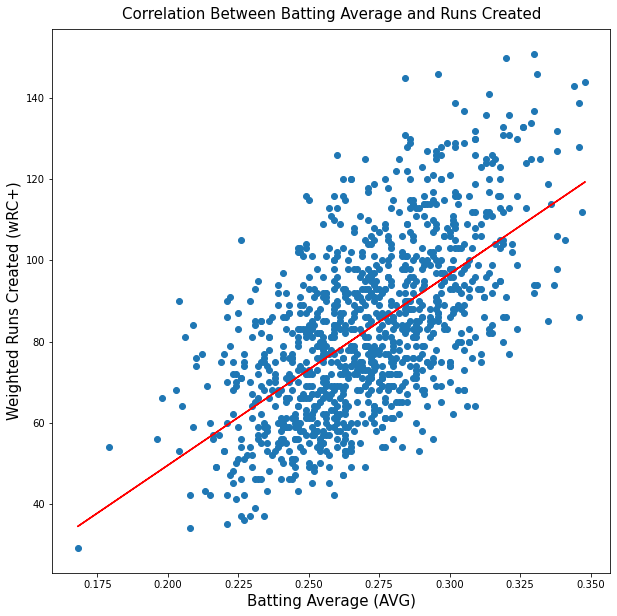

In [241]:
batting = batting_table[batting_table.PA  > 500].reset_index(drop=True)

fig, ax = plt.subplots()
ax.set_title('Correlation Between Batting Average and Runs Created', pad=10, fontsize = 15)
plt.gca().set_xlabel('Batting Average (AVG)', fontsize=15)
plt.gca().set_ylabel('Weighted Runs Created (wRC+)', fontsize=15)
plt.scatter(batting.AVG, batting['wRC+'])
fig.set_figheight(10)
fig.set_figwidth(10)

# Calculate regression line and plot it in the same graph
reg = np.polyfit(batting.AVG, batting['wRC+'], 1)
reg_fnc = np.poly1d(reg)

m_list = []
p_list = []
for i in range(0, batting.shape[0]):
    wRC_plus = batting.at[i, 'AVG']
    m_list.append(wRC_plus)
    p_list.append(reg_fnc(wRC_plus))

plt.plot(m_list, p_list, color='red')

plt.show()

As the graph shows, while there is a positive correlation between AVG and wRC+, we'd like to have the correlation be a little bit stronger. A stronger correlation to wRC+ means that the stats is more directly tied to a player being able to create runs.

#### Correlation Between OPS+ and Runs Created

Text

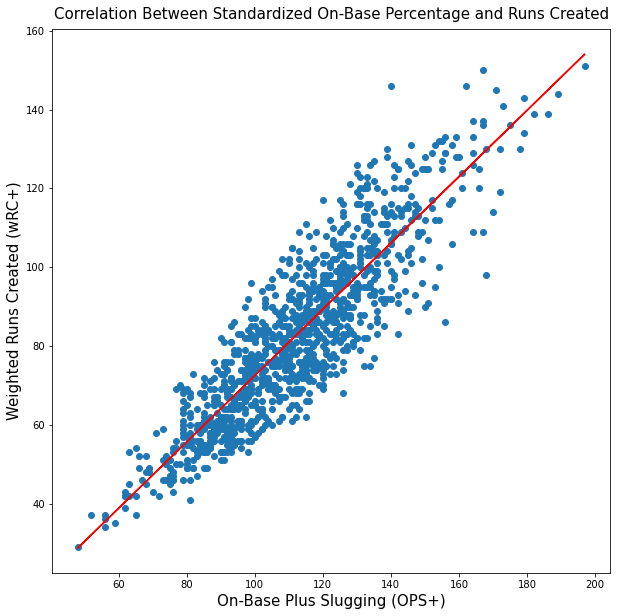

In [259]:
batting = batting_table[batting_table.PA  > 500].reset_index(drop=True)

fig, ax = plt.subplots()
ax.set_title('Correlation Between Standardized On-Base Percentage and Runs Created', pad=10, fontsize = 15)
plt.gca().set_xlabel('On-Base Plus Slugging (OPS+)', fontsize=15)
plt.gca().set_ylabel('Weighted Runs Created (wRC+)', fontsize=15)

plt.scatter(batting['OPS+'], batting['wRC+'])
fig.set_figheight(10)
fig.set_figwidth(10)

# Calculate regression line and plot it in the same graph
reg = np.polyfit(batting['OPS+'], batting['wRC+'], 1)
reg_fnc = np.poly1d(reg)

m_list = []
p_list = []
for i in range(0, batting.shape[0]):
    wRC_plus = batting.at[i, 'OPS+']
    m_list.append(wRC_plus)
    p_list.append(reg_fnc(wRC_plus))

plt.plot(m_list, p_list, color='red')

plt.show()

As you can see from the graph, OPS+ is a much stronger statsitic in showing a player's ability to create runs for his team. **TALK ABOUT CORRCOEFF** 
<br />Next, we will want to find out what makes for a high OPS+, and we will discover the players that are best at having a high OPS+. We will do this below.

First, what is OPS+?
<br />**OPS+: Normalized on-base plus slugging percentage**
> **On-Base Percentage:** The ratio of the sum of the batter's hits, walks, hit by pitches to their number of plate appearances
<br />**Slugging Percentage:** The total number of bases a player records per at-bat **(1B + 2Bx2 + 3Bx3 + HRx4)/AB**
<br />**Normalized:** Adjusts the OPS based on park factors by comparing it to league average **(OPS / league OPS) x 100**

Some factors that might impact OPS+ are Hard Hit %, Ground Ball %, Line Drive %, Fly Ball %. We will take a look at these below:

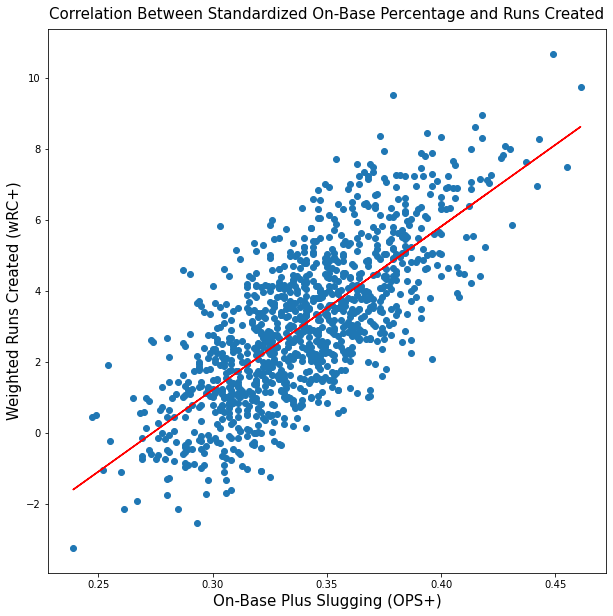

In [257]:
batting = batting_table[batting_table.PA  > 500].reset_index(drop=True)


fig, ax = plt.subplots()
ax.set_title('Correlation Between Standardized On-Base Percentage and Runs Created', pad=10, fontsize = 15)
plt.gca().set_xlabel('On-Base Plus Slugging (OPS+)', fontsize=15)
plt.gca().set_ylabel('Weighted Runs Created (wRC+)', fontsize=15)

plt.scatter(batting['wOBA'], batting['WAR'])
fig.set_figheight(10)
fig.set_figwidth(10)

# Calculate regression line and plot it in the same graph
reg = np.polyfit(batting['wOBA'], batting['WAR'], 1)
reg_fnc = np.poly1d(reg)

m_list = []
p_list = []
for i in range(0, batting.shape[0]):
    wRC_plus = batting.at[i, 'wOBA']
    m_list.append(wRC_plus)
    p_list.append(reg_fnc(wRC_plus))

plt.plot(m_list, p_list, color='red')

plt.show()

In [258]:
batting_table

,Year,Name,Pos,Age,Team,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS,OPS+,IBB,HBP,SH,SF,GIDP,WAR,WAR_def,WAR_off,BB%,K%,BB/K,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wOBA,wRC+,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Salary,Team_W,Team_L
0,2011,Ryan Roberts,3B,30,ARI,NL,143,555,482,86,120,25,2,19,65,18,9,66,98,0.249,0.341,0.427,0.768,107,2,2,3,2,6,2.43,-0.35,3.05,11.9,17.7,0.67,0.178,5.3,0.275,0.7,1.7,-0.5,72,0.339,72,0.85,11.9,34.7,41.0,10.2,12.1,41.4,35.7,22.9,21.3,53.0,25.7,423500,94,68
1,2011,Justin Upton,RF,23,ARI,NL,159,674,592,105,171,39,5,31,88,21,9,59,126,0.289,0.369,0.529,0.898,141,9,19,0,4,8,5.51,-0.33,5.12,8.8,18.7,0.47,0.240,6.0,0.319,4.8,1.7,0.1,113,0.385,113,0.82,8.8,36.9,44.8,15.8,14.8,39.8,36.0,24.3,23.8,43.4,32.8,4458333,94,68
2,2011,Stephen Drew,SS,28,ARI,NL,86,354,321,44,81,21,5,5,45,4,4,30,74,0.252,0.317,0.396,0.713,92,0,1,1,1,3,1.88,0.81,1.51,8.5,20.9,0.41,0.143,5.4,0.313,-0.6,1.2,-1.1,40,0.315,40,0.96,8.5,38.9,40.5,16.0,5.0,43.4,31.3,25.3,18.5,56.6,24.9,4650000,94,68
3,2011,Juan Miranda,1B,28,ARI,NL,65,202,174,18,37,8,2,7,23,0,1,23,48,0.213,0.315,0.402,0.717,93,1,3,2,0,1,-0.38,-0.72,0.06,11.4,23.8,0.48,0.190,3.2,0.252,-0.2,0.6,-0.6,23,0.318,23,0.78,11.4,36.8,47.2,16.9,11.9,49.2,31.3,19.5,21.1,50.8,28.1,420000,94,68
4,2011,John McDonald,SS,36,ARI,NL,19,63,59,2,10,2,0,0,2,0,0,4,9,0.169,0.222,0.203,0.426,17,0,0,0,0,0,0.20,0.54,-0.25,6.3,14.3,0.44,0.034,0.4,0.200,-0.1,0.3,0.0,1,0.197,1,0.90,6.3,36.0,40.0,10.0,0.0,54.0,28.0,18.0,18.0,72.0,10.0,1500000,94,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2021,Juan Soto,RF,22,WSN,NL,151,654,502,111,157,20,2,29,95,9,7,145,93,0.313,0.465,0.534,0.999,175,23,2,0,5,23,7.12,-0.23,6.79,22.2,14.2,1.56,0.221,3.5,0.332,0.5,-1.9,-1.9,136,0.420,136,1.83,22.2,52.7,28.7,6.7,24.4,31.2,43.5,25.4,15.9,44.9,39.1,8500000,65,97
4963,2021,Tres Barrera,C,26,WSN,NL,30,107,91,8,24,3,1,2,10,0,0,12,22,0.264,0.374,0.385,0.758,110,2,4,0,0,3,0.46,-0.04,0.67,11.2,20.6,0.55,0.121,2.4,0.328,0.6,-0.4,-0.1,15,0.333,15,1.78,11.2,46.4,26.1,27.8,11.1,33.3,44.9,21.7,31.9,43.5,24.6,570500,65,97
4964,2021,Alex Avila,C,34,WSN,NL,34,111,89,5,17,9,1,1,9,0,0,19,37,0.191,0.345,0.348,0.694,92,1,2,1,0,4,0.72,0.68,0.21,17.1,33.3,0.51,0.157,2.5,0.314,-0.9,-0.3,-0.1,13,0.311,13,1.17,17.1,40.4,34.6,5.6,5.6,37.7,41.5,20.8,9.4,56.6,34.0,1500000,65,97
4965,2021,Andrew Stevenson,CF,27,WSN,NL,109,213,192,22,44,6,0,5,23,1,1,13,61,0.229,0.294,0.339,0.632,74,2,5,2,1,3,0.09,-0.03,0.03,6.1,28.6,0.21,0.109,2.5,0.307,1.0,0.1,-0.4,19,0.276,19,1.62,6.1,49.2,30.5,10.3,12.8,32.1,42.5,25.4,15.7,51.5,32.8,579100,65,97
